# Sidekick - Project-Based Predictions

#### Model
We are approaching the problem as time series regression, considering only one project. Our dataset $\mathcal{D} = \left\{ (x_i, y_i) \mid i = 1, ..., T \right\}$ consists of $T$ observations, with $x_i$ the time index of the amount of money $y_i$. Hence, we have $X = [1, ..., T]^T$ a $(T \times 1)$ matrix of time indices and $\mathbf{y} = [y_1, ..., y_T]^T$ a vector of observed values. We model the pledged money $f(\mathbf{x})$ at time indices $\mathbf{x}$ as a Gaussian Process:

$$f(\mathbf{x}) \sim GP \left( m(\mathbf{x}), k(\mathbf{x}, \mathbf{x}') \right). $$

Our goal is to predict the future values of the pledged money $\mathbf{f}_* = \mathbf{f}_{t:T} = f(X_{t:T})$ at future time indices $X_* = X_{t:T} = [t, ..., T]^T$ after observing the values $\mathbf{y} = \mathbf{y}_{1:t} = [y_1, ..., y_t]^T$ at time indices $X = X_{1:t} = [1, ..., t]^T$. In the GP framework, we can compute this prediction using

$$\mathbf{f}_* \mid X, \mathbf{y}, X_* \sim \mathcal{N}\left(\overline{\mathbf{f}}_*, \text{ cov}(\mathbf{f}_*)  \right) \\
\overline{\mathbf{f}}_* = K(X_*, X) \left[ K(X, X) + \sigma_n^2I \right]^{-1}\mathbf{y} \\
\text{cov}(\mathbf{f}_*) = K(X_*, X_*) - K(X_*, X)\left[ K(X, X) + \sigma_n^2I \right]^{-1}K(X, X_*).
$$ 

Finally, the kernel's (hyper)parameters $\theta_*$ are learned by maximizing the *log marginal likehood*

$$\theta_* = \underset{\theta} {\arg\max} \log p(\mathbf{y} \mid X, \theta) = \underset{\theta} {\arg\max} \left\{ -\frac{1}{2}\mathbf{y}^T \left[ K+ \sigma_n^2I \right]^{-1}\mathbf{y} -\frac{1}{2}\log det\left[K+ \sigma_n^2I\right] -\frac{T}{2}\log 2\pi \right\},$$

with $K = K(X, X)$.

#### Results
The major problem in this context was that the predictive mean $\mathbf{f}_*$ always falls back to the mean $m(\mathbf{x})$ very quickly. One solution has been to combine two squared-exponential kernels and initializing one of them to a large length-scale in order to capture the global trend. This yields to some reasonable result. However, when applying the same model to another ones ($\theta$ learned over one project and used to predict another) gives very poor performance.



## Import
Import and general settings. Should be run every time at first.

In [3]:
%matplotlib inline
import os
import sys
sys.path.insert(0, os.path.abspath('../utils/')) # Add sibling to Python path
sys.path.insert(0, os.path.abspath('../src/')) # Add sibling to Python path
sys.stdout.flush() # Print output on the fly in Notebook
import matplotlib
matplotlib.rcParams['figure.figsize'] = (18,8)
matplotlib.rcParams['font.size'] = 16
matplotlib.rcParams['legend.fontsize'] = 16
from IPython.display import display
import numpy as np
import GPy
import pickle as cp
import matplotlib.pyplot as plt
from math import floor
from dataset import Sidekick

DATA_DIR = "../data/sidekick"

## Load data
This operation takes a lot of time, should be done only once.

In [4]:
sk = Sidekick()
project = sk['14035777']

## Plot status
Plot the pledged money and number of backers of the same figure.

Goal: $2500
Pledged: $2905


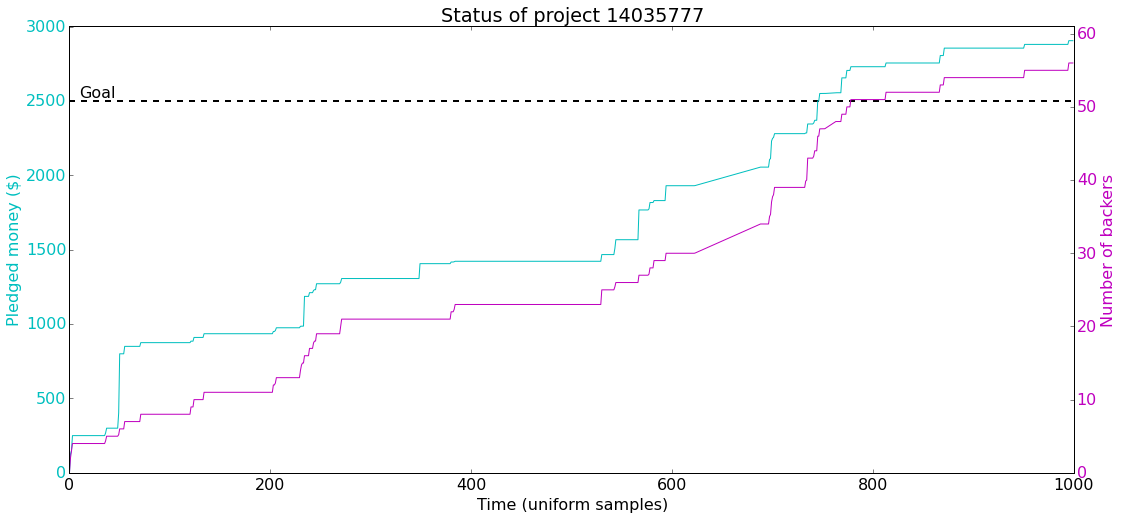

In [5]:
project.plot()

## Processing
We keep only the observations where there is a change from the previous one in order to reduce the quantity of data. The training and testing sets are also extracted. 

**Default size**: 80% for trainig, 20% for testing

In [6]:
threshold = 0.8
money = project.money
time, money = project.resample(money)
x_train, y_train, x_test, y_test = project.split(time, money, threshold)

## Training
Perform the regression on the training set.

### Kernels
We define some kernels to be tried.

In [7]:
# Primitives
LIN = GPy.kern.Linear(input_dim=1)
SE = GPy.kern.RBF(input_dim=1)
BR = GPy.kern.Brownian(input_dim=1) # √
POLY = GPy.kern.Poly(input_dim=1, order=3) # x
RQ = GPy.kern.RatQuad(input_dim=1)
WN = GPy.kern.White(input_dim=1)
MAT32 = GPy.kern.Matern32(input_dim=1)
MAT52 = GPy.kern.Matern52(input_dim=1)
CP200 = GPy.kern.ChangePointBasisFuncKernel(input_dim=1, changepoint=200)
CP400 = GPy.kern.ChangePointBasisFuncKernel(input_dim=1, changepoint=400)
DOM1 = GPy.kern.DomainKernel(input_dim=1, start=-1, stop=300)
DOM2 = GPy.kern.DomainKernel(input_dim=1, start=299, stop=500)
DOM3 = GPy.kern.DomainKernel(input_dim=1, start=499, stop=700)
DOM4 = GPy.kern.DomainKernel(input_dim=1, start=600, stop=1000)
DOM5 = GPy.kern.DomainKernel(input_dim=1, start=399, stop=500)
DOM6 = GPy.kern.DomainKernel(input_dim=1, start=499, stop=100)

#BIAS = GPy.kern.Bias()

# Combined
LIN_LINxSE = LIN.copy() + LIN.copy() * SE.copy() # √
SE_LINxSE = SE.copy() + LIN.copy() * SE.copy()
SE_SExSE = SE.copy() + SE.copy() * SE.copy()
LINxSE = LIN.copy() + SE.copy()
LINxLIN = LIN.copy() + LIN.copy()
BRxSE = BR.copy() * SE.copy()
BR_SE = BR.copy() + SE.copy()
BR_SExLIN = BR.copy() + SE.copy() * LIN.copy()
BRxBR = BR.copy() * BR.copy()
BR_BR = BR.copy() + BR.copy()
SE_POLY = SE.copy() * POLY.copy() # x
RQxSE = RQ.copy() + SE.copy() # √
LINxSE_RQxSE = RQxSE.copy() + LINxSE.copy()
LINxSE_SE = RQxSE.copy() + SE.copy()
LIN_RQ = LIN.copy() + RQ.copy()
LINxRQ = LIN.copy() * RQ.copy() # √
LINxRQxBR = LINxRQ.copy() * BR.copy() # √
LINxRQ_BR = LINxRQ.copy() + BR.copy()
LINxRQxBR_SE = LINxRQxBR.copy() + SE.copy()
RQxSE_WN = RQxSE.copy() + WN.copy()
POLY_SE = POLY.copy() + SE.copy()
LIN_MAT32 = LIN.copy() + MAT32.copy()
LIN_MAT52 = LIN.copy() + MAT52.copy()

# Piece-wise
DOM300 = GPy.kern.DomainKernel(input_dim=1, start=-1, stop=384)
DOM500 = GPy.kern.DomainKernel(input_dim=1, start=-1, stop=525)
DOM1000 = GPy.kern.DomainKernel(input_dim=1, start=525, stop=1000)

### Regression

Optimization restart 1/2, f = -741.7268087025851
Optimization restart 2/2, f = -824.9961082728179


GP_regression.,value,constraints,priors
sum.rbf.variance,0.000285410909212,+ve,
sum.rbf.lengthscale,2.21167655972,+ve,
sum.rbf_1.variance,0.262897046346,+ve,
sum.rbf_1.lengthscale,58.4667284571,+ve,
Gaussian_noise.variance,1.23195228302e-15,+ve,


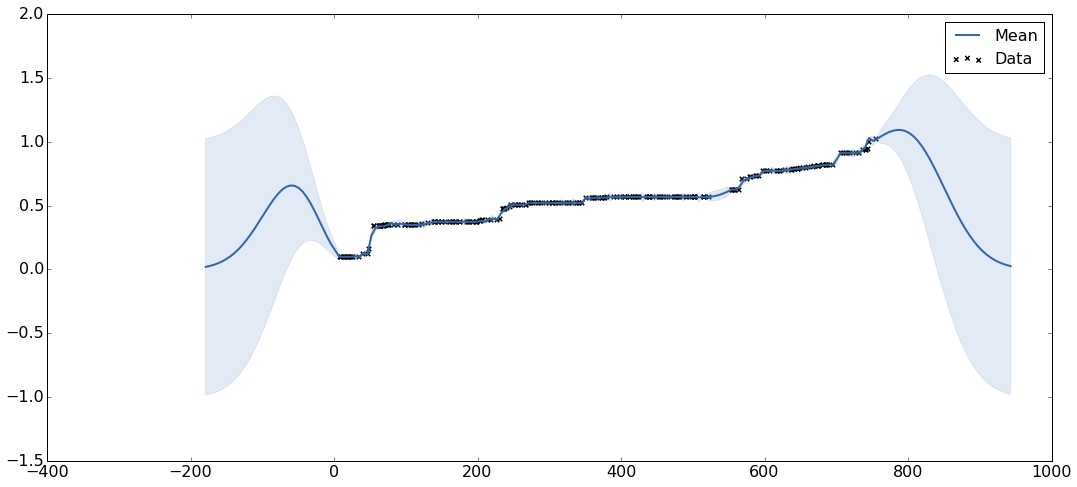

In [12]:
#kernel = SE.copy()
kernel = GPy.kern.RBF(input_dim=1, lengthscale=500)
kernel = GPy.kern.RBF(input_dim=1, lengthscale=500) + SE.copy()
#kernel = GPy.kern.RBF(input_dim=1, lengthscale=500) + RQ.copy()
#kernel = GPy.kern.RatQuad(input_dim=1, lengthscale=600)
#kernel = GPy.kern.RatQuad(input_dim=1, lengthscale=500) + RQ.copy()

X = np.ndarray(shape=(len(x_train), 1), buffer=x_train, dtype=int)
Y = np.ndarray(shape=(len(y_train), 1), buffer=y_train, dtype=float)

m = GPy.models.GPRegression(X, Y, kernel)

#mf = GPy.mappings.Linear(input_dim=1, output_dim=1)
#m = GPy.models.GPRegression(X, Y, kernel, mean_function=mf)

m.optimize()
m.optimize_restarts(num_restarts=2)

display(m)
fig = m.plot()

## Evaluation
Predict the last 20% (test sets) and displays the Root Mean Squared Error and plots the model. In red, the predictions, in blue the actual values.

RMSE on test set: 0.694388876133


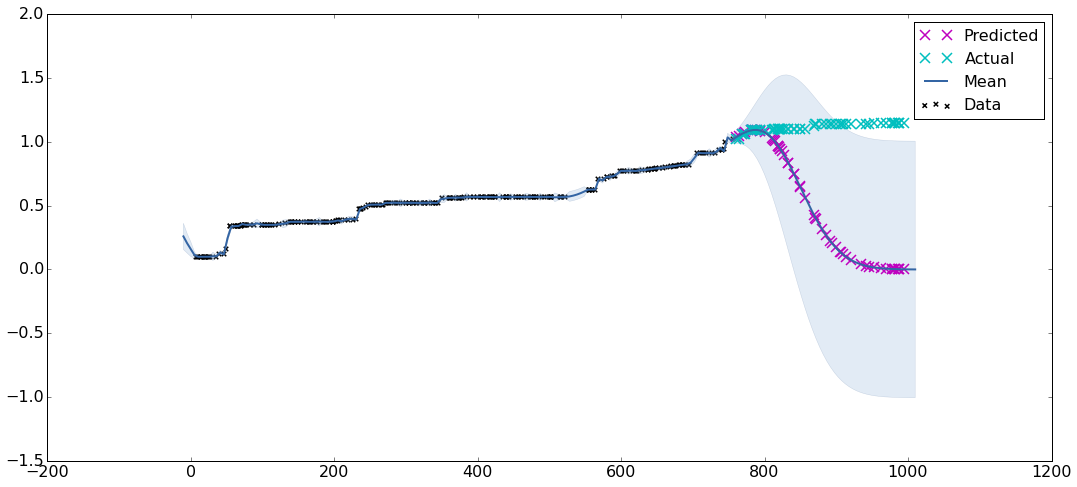

In [14]:
def rmse(x, y):
    return np.sqrt(np.mean(np.square(x - y)))

Xnew = np.ndarray((len(x_test),1), buffer=x_test, dtype=int)
mean, var = m.predict(Xnew)
Ypredict = mean

print("RMSE on test set: %s" % rmse(y_test, Ypredict))
fig = plt.figure()
ax = fig.add_subplot(111)
#ax.errorbar(Xnew, Ypredict, 2*np.sqrt(var), color='r', marker='x', linestyle=".")
ax.plot(Xnew, Ypredict, 'mx', mew=1.5, ms=10, label="Predicted")
ax.plot(x_test, y_test, 'cx', mew=1.5, ms=10, label="Actual")
ax.legend(loc=2, numpoints=1)
model_plot = m.plot(ax=ax, plot_limits=[-10, 1010])